In [1]:
import pandas as pd
from COMETH import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import glob
import json

gui = nimble.NimbleGUI()
gui.serve(8090)
gui.nativeAPI().clear()

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8090


In [ ]:
# Refactoring fatto
def create_body_model(action_name: str, action_dict: dict, vicon_path: str = './totalcapture/vicon', body_node_list: list = ['humerus_r','humerus_l',"thorax"]):
    """ 
    This function initializes the DynamicSkeleton body model with the vicon data of the given subject
    Parameters:
        - action_name: The name of the specific action to consider ('subj/action')
        - action_dict: The dict of the specific action to consider
    Returns:
        The DynamicSkeleton
    """

    subj = action_name.split('/')[-2]
    action = action_name.split('/')[-1]
    path = os.path.join(vicon_path,action_name,'vicon_'+subj+'_'+action+'.csv')

    # Build skeleton
    s12 = Skeleton('BODY12.xml')
    # BSM
    s = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file=os.path.abspath('COMETH/bsm_upper.osim'))
    s.hip_correction = False

    # Read data from CSV
    markers = pd.read_csv(path)
    # Build the markers dataframe with only the subset we are interested in
    Rz = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    Rx = np.array([
        [1,0,0 ],
        [0,0,-1 ],
        [0,1,0]
    ])

    markers.columns
    markers_dict = {
        'RKnee': 'right_knee',
        'LWrist': 'left_wrist',
        'RHip': 'right_hip',
        'RShoulder': 'right_shoulder',
        'LElbow': 'left_elbow',
        'LHip': 'left_hip',
        'RElbow': 'right_elbow',
        'RWrist': 'right_wrist',
        'LKnee': 'left_knee',
        'LShoulder': 'left_shoulder',
        'RAnkle': 'right_ankle',
        'LAnkle': 'left_ankle'
    }

    sensors_dict = {
        'ulna_r': 'right_elbow',
        'ulna_l': 'left_elbow',
        'thorax': 'sternum',
        'humerus_r': 'right_elbow',
        'humerus_l': 'left_elbow'
        #TODO: complete with other accelerometer
    }

    offset_dict = {
        'ulna_r': [0,0,0],
        'ulna_l': [0,0,0],
        'humerus_r': [-0.04,-0.15,0],
        'humerus_l': [-0.04,-0.15,0],
        'thorax': [0.1, -0.1, 0.05]
    }

    rotation_dict = {
        'humerus_r': np.array([[0,0,-1],[1,0,0],[0,-1,0]]),
        'humerus_l': np.array([[0,0,-1],[1,0,0],[0,-1,0]]),
        'thorax': np.array([[0,0,1],[1,0,0],[0,1,0]])
    }

    """ rotation_dict = {
        'humerus_r': np.eye(3),
        'humerus_l': np.eye(3),
        'thorax': np.eye(3)
    } """


    target = []
    for i in range(markers.shape[0]):
        row = []
        for kp in markers_dict.keys():
            p = np.array([markers[markers_dict[kp]+"_x"][i],markers[markers_dict[kp]+"_y"][i],markers[markers_dict[kp]+"_z"][i]])
            # rotate the 3d point -90 on the x axis (from y up to z up)
            p_n = Rz.dot(Rx.dot(p))
            # print(p,p_n)
            row += p_n.tolist()
        target.append(row)
    target = np.array(target)

    # Move the body model using gt to the first position
    s.reset()
    s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    s.exact_scale()
    s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))

    
    from typing import List, Tuple
    from scipy.spatial.transform import Rotation

    sensors: List[Tuple[nimble.dynamics.BodyNode, nimble.math.Isometry3]] = []
    for node in body_node_list:
        body_node: nimble.dynamics.BodyNode = s._nimble.getBodyNode(node)
        quatern_bone = action_dict[sensors_dict[node]]['calib_bone']
        quatern_ref = action_dict[sensors_dict[node]]['calib_ref']
        #translation: np.ndarray = np.array([0.0, 0.0, 0.0]) #TODO: Where can i find the translation?
        translation: np.ndarray = np.array(offset_dict[node])
        #rotation: np.ndarray = (Rotation.from_quat(quatern_ref)).as_matrix()@np.linalg.inv((Rotation.from_quat(quatern_bone)).as_matrix())
        #rotation: np.ndarray = (Rotation.from_quat(quatern_bone)).as_matrix()
        #rotation: np.ndarray = np.eye(3)
        rotation: np.ndarray = np.array(rotation_dict[node])

        #rotation: np.ndarray = np.linalg.inv((Rotation.from_quat(quatern_bone)).as_matrix()) # in teoria nel readme le calibration sono vector first
        watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

        sensors.append((body_node, watch_offset))
    
    s.IMUs = sensors

    return s

def plot_imu(imu,axis_length=0.1,imu_key='imu'):
    j_w = imu[0].getWorldTransform().matrix()   # From joint to world
    imu_j = imu[1].matrix()                     # From IMU to joint
    imu_w = j_w @ imu_j # From IMU to world
    
    # Origin
    p0 = imu_w @ np.eye(4)
    gui.nativeAPI().createSphere(key=imu_key+'o', radii=np.array([0.01,0.01,0.01]),pos=p0[0:3,3],color=np.array([255,255,0,1]))
    
    # X coordinate
    px = np.eye(4)
    px[0:3,3] = [axis_length,0,0]
    px = imu_w @ px
    gui.nativeAPI().createLine(key=imu_key+'x',points=[p0[0:3,3],px[0:3,3]],color=np.array([255,0,0,1]))
    
    # Y coordinate
    py = np.eye(4)
    py[0:3,3] = [0,axis_length,0]
    py = imu_w @ py
    gui.nativeAPI().createLine(key=imu_key+'y',points=[p0[0:3,3],py[0:3,3]],color=np.array([0,255,0,1]))
    
    # Z coordinate
    pz = np.eye(4)
    pz[0:3,3] = [0,0,axis_length]
    pz = imu_w @ pz
    gui.nativeAPI().createLine(key=imu_key+'z',points=[p0[0:3,3],pz[0:3,3]],color=np.array([0,0,255,1]))

In [ ]:
# Refactoring fatto
def compute_gt(action_name: str, vicon_path: str):
    subj = action_name.split('/')[-2]
    action = action_name.split('/')[-1]
    path = os.path.join(vicon_path,action_name,'vicon_'+subj+'_'+action+'.csv')

    # Build skeleton
    s12 = Skeleton('BODY12.xml')
    # BSM
    s = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file=os.path.abspath('COMETH/bsm_upper.osim'))
    s.hip_correction = False

    # Read data from CSV
    markers = pd.read_csv(path)

    # Build the markers dataframe with only the subset we are interested in
    Rz = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    Rx = np.array([
        [1,0,0 ],
        [0,0,-1 ],
        [0,1,0]
    ])

    markers.columns
    markers_dict = {
    'RKnee': 'right_knee',
    'LWrist': 'left_wrist',
    'RHip': 'right_hip',
    'RShoulder': 'right_shoulder',
    'LElbow': 'left_elbow',
    'LHip': 'left_hip',
    'RElbow': 'right_elbow',
    'RWrist': 'right_wrist',
    'LKnee': 'left_knee',
    'LShoulder': 'left_shoulder',
    'RAnkle': 'right_ankle',
    'LAnkle': 'left_ankle'
    }
    target = []
    for i in range(markers.shape[0]):
        row = []
        for kp in markers_dict.keys():
            p = np.array([markers[markers_dict[kp]+"_x"][i],markers[markers_dict[kp]+"_y"][i],markers[markers_dict[kp]+"_z"][i]])
            # rotate the 3d point -90 on the x axis (from y up to z up)
            p_n = Rz.dot(Rx.dot(p))
            # print(p,p_n)
            row += p_n.tolist()
        target.append(row)
    target = np.array(target)
    gui.nativeAPI().clear()
    # Move the body model using gt to the first position
    kps = list(markers_dict.keys())
    s.reset()
    s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    s.exact_scale()
    
    q0 = s._nimble.getPositions().copy()
    positions = []

    for i in range(0, target.shape[0]):
        #Update gt position
        s12.load_from_numpy(target[i,:].reshape(-1,3),s.kps)
        s.load_from_BODY12(s12)
        
        s.exact_scale(max_iterations=1000, to_scale=False)
        pos_gt = s._nimble.getPositions().copy()
        pos_gt[3:6] = q0[3:6]
        #s._nimble.setPositions(pos_gt)
        positions.append(pos_gt.reshape(-1,1))
        
        #time.sleep(0.1)
    
    return np.array(positions)

def new_compute_gt(action_name: str, vicon_path: str):
    subj = action_name.split('/')[-2]
    action = action_name.split('/')[-1]
    path = os.path.join(vicon_path,action_name,'vicon_'+subj+'_'+action+'.csv')

    # Read data from CSV
    markers = pd.read_csv(path)

    # Build the markers dataframe with only the subset we are interested in
    Rz = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    Rx = np.array([
        [1,0,0 ],
        [0,0,-1 ],
        [0,1,0]
    ])

    markers.columns

    makers_list = ['hip','right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist']
    target = []
    for i in range(markers.shape[0]):
        row = []
        for kp in makers_list:
            p = np.array([markers[kp+"_x"][i],markers[kp+"_y"][i],markers[kp+"_z"][i]])
            # rotate the 3d point -90 on the x axis (from y up to z up)
            p_n = Rz.dot(Rx.dot(p))
            # print(p,p_n)
            row += p_n.tolist()
        target.append(row)
    target = np.array(target).reshape(markers.shape[0],7,3)

    offset = target[0,0,:].reshape(3)
    positions = []
    for i in range(0, target.shape[0]):
        positions.append(target[i,:,:]- (target[i,0,:].reshape(3) - offset ))

    
    return np.array(positions)

In [ ]:
# Refactoring fatto
import cvxpy as cp
from scipy.signal import firwin

def fir_filter(numtaps : int = 200):
    fs = 60  # sampling
    fc = 10    # cut
    b= firwin(numtaps, fc/(fs/2), window='hamming')
    return b

class MultiJointKalman3D:
    """
    Filtro di Kalman vettoriale per N giunti, stato [pos, vel, acc].
    Ogni giunto è indipendente ma calcolato in blocco.
    """
    def __init__(self, n_joints=49, dt=1/60,
                 q_var_pos=1e-6, q_var_vel=1e-4, q_var_acc=1e-2,
                 r_var=1e-1):
        self.n = n_joints
        self.dt = dt

        dt2 = 0.5 * dt * dt
        self.A = np.array([[1, dt, dt2],
                           [0, 1, dt],
                           [0, 0, 1]], dtype=float)
        self.H = np.array([1, 0, 0], dtype=float)
        self.Q = np.diag([q_var_pos, q_var_vel, q_var_acc])
        self.R = r_var

       
        self.x = np.zeros((n_joints, 3))             # [pos, vel, acc]
        self.P = np.tile(np.eye(3), (n_joints, 1, 1)) * 1e-2 

    def update(self, q_meas, s, q = None, r = None):
        
        if q is not None:
            Q = np.diag(q)
        else:
            Q = self.Q

        if r is not None:
            R = r
        else:
            R = self.R
        
        q_meas = np.asarray(q_meas).reshape(self.n)

        # Prediction
        x_pred = self.x @ self.A.T
        P_pred = np.einsum('ij,njk,kl->nil', self.A, self.P, self.A.T) + Q

        # Innovation
        PHt = np.einsum('nij,j->ni', P_pred, self.H)
        S = np.einsum('i,ni->n', self.H, PHt) + R
        K = PHt / S[:, None]
        z_pred = np.einsum('ni,i->n', x_pred, self.H)
        y = q_meas - z_pred

        # Update
        self.x = x_pred + K * y[:, None]
        self.P = P_pred - np.einsum('ni,nj->nij', K, PHt)

        if r is not None:
            self.P = np.tile(np.eye(3), (49, 1, 1)) * 1e-2
        
        return self.x[:, 0], self.x[:, 1], self.x[:, 2]
    


def estimate_position_from_IMUs_qp(s,acc_target=None, gyro_target=None, position_target=None, max_iterations=100, precision=0.0001, dt=1/60):
    
    
    # Variable declaration
    dq = cp.Variable((49,))
    delta_a =  cp.Variable((9,))
    delta_w =  cp.Variable((9,))
    dq_cumulative = cp.Variable((49,))
    
    # Acc
    if acc_target is not None:
        a = cp.Parameter((9,))
        aT = cp.Parameter((9,)) 
        Ja = cp.Parameter((9,49))
    
    # Gyro
    if gyro_target is not None:
        w = cp.Parameter((9,))
        wT = cp.Parameter((9,)) 
        Jw = cp.Parameter((9,49))

    # Pos from HPE
    if position_target is not None:
        mask = np.array([~np.isnan(t) for t in position_target])
        nkey = int(np.sum(mask[:,0]))
        subsets_joints = [([position_target[i] for i in range(len(position_target)) if mask[i,0]])]
        x = cp.Parameter((nkey*3))
        xT = cp.Parameter((nkey*3))
        Jp = cp.Parameter((nkey*3,49))
        delta_p = cp.Variable((nkey*3,))
    else:
        delta_p = None
    
    # Position
    q = cp.Parameter((49,))
    q_l = cp.Parameter((49,))
    q_u = cp.Parameter((49,))
    dq_l = cp.Parameter((49,))
    dq_u = cp.Parameter((49,))

    
    # Problem building
    constraints = []
    if acc_target is not None:
        constraints += [a + Ja@dq + delta_a == aT]
    
    if gyro_target is not None:
        constraints += [w + 1*Jw@dq + delta_w == wT]

    if position_target is not None:
        constraints += [x + Jp@dq + delta_p== xT]
    
    dq_cumulative.value = np.zeros(q.shape)
    
    constraints += [dq <= q_u - q]
    constraints += [dq >= q_l - q]
    constraints += [dq_cumulative + dq >= dq_l, dq_cumulative + dq <= dq_u]  # velocity
    #constraints += [dq >= dq_l, dq <= dq_u]  # velocity limit
                         
    lambda_reg  = 10
    weight_acc  = 100 if acc_target is not None else 0.0
    weight_gyro = .01 if gyro_target is not None else 0.0
    weight_hpe = 10000 if position_target is not None else 0.0

    #da commentare per good complementary
    if acc_target is not None and position_target is not None:
        weight_acc = 1

    to_minimize = (
        lambda_reg * cp.sum_squares(dq) +
        weight_acc * cp.sum_squares(delta_a) +
        weight_gyro * cp.sum_squares(delta_w) +
        weight_hpe * cp.sum_squares(delta_p)
    )

    obj = cp.Minimize(to_minimize)
    prob = cp.Problem(obj, constraints)
    
    q_l.value = np.clip(s.q_l,-1000,1000)
    q_u.value = np.clip(s.q_u,-1000,1000)
    dq_l.value = dt*s.qdot_l
    dq_u.value = dt*s.qdot_u

    if position_target is not None:
        dq_l.value = dt*1000*s.qdot_l
        dq_u.value = dt*1000*s.qdot_u
    i=0
    
    while i < max_iterations:
        i+=1
        # Parameters initialization
        q.value = s._nimble.getPositions()

        if acc_target is not None:
            aT.value = acc_target
            a.value = s._nimble.getAccelerometerReadings(s.IMUs)
            Ja.value = s._nimble.getAccelerometerReadingsJacobianWrt(accs=s.IMUs, wrt=nimble.neural.WRT_POSITION)
        
        if gyro_target is not None:
            wT.value = gyro_target
            w.value = s._nimble.getGyroReadings(s.IMUs)
            Jw.value = s._nimble.getGyroReadingsJacobianWrt(gyros=s.IMUs, wrt=nimble.neural.WRT_POSITION)
        
        if position_target is not None:
            xT.value = np.array(subsets_joints).reshape(-1)
            x.value = s._nimble.getJointWorldPositions(s.joints)[mask.reshape(-1)]
            Jp.value = s._nimble.getJointWorldPositionsJacobianWrtJointPositions(s.joints)[mask.reshape(-1)]
        

        prob.solve(solver=cp.OSQP, warm_start=True)

        dq_cumulative.value = np.array(dq_cumulative.value) + np.array(dq.value)

        s._nimble.setPositions(q.value + dq.value)
        #s._nimble.setVelocities(dq_cumulative / dt)
        #dq_cumulative.value = dq_cumulative.value + dq.value

        if np.linalg.norm(dq.value.flatten()) < precision:
            #if position_target is not None:
            #    print(f"Exit value: {np.linalg.norm(dq.value.flatten())} \n Pos error: {qT.value-q.value-dq.value}")
            #print(f"Exit due to reached precision, after {i} iterations, Exit value: {np.linalg.norm(dq.value.flatten())}")
            break


    #if acc_target is not None:
    #    print(f"N cond matrici IMU ultima iterazione : {np.linalg.cond(Ja.value[0:3],p=2)}, {np.linalg.cond(Ja.value[3:6], p=2)}, {np.linalg.cond(Ja.value[6:9], p=2)}")
    
    #Setting new velocity
    #s._nimble.setVelocities(dq_cumulative.value/dt)

In [5]:
#Refactoring fatto, magari da trasferire in DynamicSkeleton
#To transfer inside DynamicSkeleton class
def getImuWorldOrient(s):
    #return the imu "from imu to world" rotation as transfrom matrix.
    rot = []
    for imu in s.IMUs:
        T_b_w = imu[0].getWorldTransform().matrix()
        T_i_b = imu[1].matrix()

        T_i_w = T_b_w @ T_i_b

        rot.append(T_i_w)
    
    return np.array(rot)

def getImuWorldPosition(s):
    pos = []
    for imu in s.IMUs:
        T_b_w = imu[0].getWorldTransform().matrix()
        T_i_b = imu[1].matrix()

        T_i_w = T_b_w @ T_i_b
        pos.append(T_i_w[:3,3].reshape(3))
        
    return np.array(pos)

def correctImuOrient(s, R_corr):
    """ R_corr è (Nx3x3) ed è da old imu a new imu """
    
    for i, imu in enumerate(s.IMUs):
        T_i_b = imu[1].matrix()
        T = np.eye(4)
        T[:3,:3]= R_corr[i]

        T_corr = T@T_i_b

        s.IMUs[i] = (imu[0],nimble.math.Isometry3(T_corr[:3,:3], T_corr[:3,3]))# R_t_b[i] offset_t_b[i]


def setImuWorldTransform(s, T_i_w):
    """WARNING: FOR NOW ONLY THE ROTATION IS APPLIED!!!"""
    for i, imu in enumerate(s.IMUs):
        T_b_w = imu[0].getWorldTransform().matrix()
        T_old = imu[1].matrix()
        T_i_b = np.linalg.inv(T_b_w)@T_i_w[i]
        s.IMUs[i] = (imu[0],nimble.math.Isometry3(T_i_b[:3,:3], T_old[:3,3]))

In [ ]:
#Refactoring Fatto
from sf_utils import input_sim, rotation
from sf_utils.metrics import body_pose_metrics
class ComplementaryFilter:
    def __init__(self, alpha=0.95):#0.95
        self.alpha = alpha
        self.roll = 0#0.14860117#-1.38105158
        self.pitch = 0#0.06376184 #-0.40578436
        self.yaw = 0#2.73863871#3.00649334
        self.prev_acc = 0
        self.prev_gyro = 0

    def update(self, accel, gyro, dt= 1/60):
        """
        accel: [ax, ay, az] in m/s^2
        gyro: [gx, gy, gz] in rad/s
        dt: timestep in seconds
        """
        ax, ay, az = accel
        gx, gy, gz = gyro

        cr = np.cos(self.roll)
        sr = np.sin(self.roll)

        cp = np.cos(self.pitch)
        sp = np.sin(self.pitch)

        if np.abs(cp)<0.0001:
            if cp > 0 :
                cp = np.cos(np.deg2rad(89.99))
                sp = np.sin(np.deg2rad(89.99))
            else:
                cp = np.cos(np.deg2rad(90.01))
                sp = np.sin(np.deg2rad(90.01))

        # Integrate gyro to get angles
        self.roll += gx * dt + sr*(sp/cp)*gy*dt + cr*(sp/cp)*gz*dt
        self.pitch += cr*gy * dt - sr*gz*dt
        self.yaw += (sr/cp)*gy*dt+(cr/cp)*gz *dt

        # Compute angles from accelerometer
        roll_acc = np.arctan2(ay, az)
        pitch_acc = np.arctan2(-ax, np.sqrt(ay**2 + az**2))

        if np.abs(np.linalg.norm(accel)-1)>0.2:
            alpha = 1
        elif np.abs(np.linalg.norm(accel)-1)<0.001:
            alpha = 0#0
        else:
            alpha = self.alpha
        # Apply complementary filter
        self.roll = alpha * self.roll + (1 - alpha) * roll_acc
        self.pitch = alpha * self.pitch + (1 - alpha) * pitch_acc

        return self.roll, self.pitch, self.yaw

    def correct(self, T):
        #self.roll, self.pitch, self.yaw = rotation.rotmat_to_euler(T[:3,:3])
        self.roll, self.pitch, self.yaw = rotation.rotmat_to_euler(T[:3,:3])

    def correct_only_yaw(self, T):
        a, b, self.yaw = rotation.rotmat_to_euler(T[:3,:3])
        
    def correct_drift(self, angles_drift):
        self.roll = self.roll-angles_drift[0]
        self.pitch = self.pitch - angles_drift[1]
        self.yaw = self.yaw - angles_drift[2]

    def get_rotmat(self):
        cr, sr = np.cos(self.roll), np.sin(self.roll)
        cp, sp = np.cos(self.pitch), np.sin(self.pitch)
        cy, sy = np.cos(self.yaw), np.sin(self.yaw)
        
        # Rotation matrix from body to world (ZYX)
        R = np.array([
            [cy*cp, cy*sp*sr - sy*cr, cy*sp*cr + sy*sr],
            [sy*cp, sy*sp*sr + cy*cr, sy*sp*cr - cy*sr],
            [-sp,    cp*sr,            cp*cr]
        ])

        return R

In [15]:
pos_gt = compute_gt('s1/acting1', './totalcapture/vicon/')

In [16]:
#Refactoring Fatto
def camera_simulation(body_pos, camera_pos, fov_h = 1.78024, fov_v = 0.994838, R_cam = np.eye(3)):
    """
    Function use to simulate an egocentric camera behavior in identifing human keypoint. Camera considerata con lo z in fuori.
    ## Args
    - body_pos : human body keypoints 3d absolute positions as a matrix (N,3)
    - camera_pos : camera absolute 3D position as (3)
    - fov_h, fov_v : angular width of camera view in rad (horizontal and vertical)
    - R_cam : orientation of camera as a (3,3) Rotation matrix (camera --> world)
    ## Return
    - The body_pos array, with NaN if the joint is not visible
    """
    points_rel = body_pos - camera_pos # Nx3
    points_cam = points_rel @ R_cam  # Nx3

    x = points_cam[:, 0]
    y = points_cam[:, 1]
    z = points_cam[:, 2]

    in_front = z > 0

    theta_h = np.arctan2(y, z)
    theta_v = np.arctan2(x, z)

    in_fov_h = np.abs(theta_h) <= fov_h / 2
    in_fov_v = np.abs(theta_v) <= fov_v / 2

    visible = in_front & in_fov_h & in_fov_v
    
    if not np.any(visible):
        return None

    
    # Nan for non-visible joints
    points_filtered = body_pos.copy().astype(float)
    points_filtered[~visible] = np.nan

    return points_filtered

In [17]:
# Refactoring fatto
class ImuData:
    def __init__(self, path: str):
        """ 
        Parameters
         path: str root directory of the imu sequence
        """
        self.file_path = path
        self.action = path.split('_')[-1].split('.')[0]
        self.subj = path.split('_')[-2]
        self.root_path, self.file_name = os.path.split(path)
        self.cal_file = self.subj + '_' + self.action + '_calibration.json'
        self.acc_read = None
        
    def read_imu_csv(self):
        """ 
        This function return a dict of numpy matrices (n_t x n_comp) representing the imu data of the given .csv.
        """
        # Loading data from files
        data = pd.read_csv(self.file_path, index_col=0)
        if data is None:
            return

        with open(os.path.join(self.root_path, self.cal_file), 'r') as file:
            calibration = json.load(file)

        indexes_name = data.columns.values

        # Obtaining acc names
        acc_readings = {}
        for idx in indexes_name[list(range(2,len(indexes_name),16))]:
            if 'left' in idx or 'right' in idx:
                name = idx.split('_')[0] +'_'+ idx.split('_')[1]
            else:
                name = idx.split('_')[0]
            acc_readings[name] = {}

            quaternion = data.loc[:,[name+'_quat_w', name+'_quat_x', name+'_quat_y', name+'_quat_z']]
            acc_readings[name]['quater']= quaternion.to_numpy()

            accel = data.loc[:,[name+'_acc_x', name+'_acc_y', name+'_acc_z']]
            acc_readings[name]['accel']= accel.to_numpy()

            gyro = data.loc[:,[name+'_gyro_x', name+'_gyro_y', name+'_gyro_z']]
            acc_readings[name]['gyro']= np.deg2rad(gyro.to_numpy())

            comp = data.loc[:,[name+'_comp_x', name+'_comp_y', name+'_comp_z']]
            acc_readings[name]['comp']= comp.to_numpy()

            grav = data.loc[:,[name+'_g_x', name+'_g_y', name+'_g_z']]
            acc_readings[name]['grav']= grav.to_numpy()

            acc_readings[name]['calib_bone'] = np.array(calibration['bone'][name])
            acc_readings[name]['calib_ref'] = np.array(calibration['ref'][name])
        
        acc_readings['n_frames'] = len(data.index)

        self.acc_read = acc_readings

    def get_imu_array(self, joint_list):
        acc =[]
        gyro = []
        for joint in joint_list:
            acc.append(self.acc_read[joint]['accel'])
            gyro.append(self.acc_read[joint]['gyro'])

        return np.array(acc), np.array(gyro)
    
    def get_world_orient(self, joint_list):
        ori = []
        for joint in joint_list:
            
            quat_ref = np.tile(self.acc_read[joint]['calib_ref'], (len(self.acc_read[joint]['quater']),1))
            #ori.append(rotation.batch_quat_mul(rotation.quat_vectorfirst_to_scalarfirst(quat_ref),self.acc_read[joint]['quater']))
            ori.append(self.acc_read[joint]['quater'])
        
        return np.array(ori)

In [18]:
# Refactoring Non Necessario
import matplotlib.pyplot as plt
def plot_error(error):
    metrics_df = pd.DataFrame({
    "MPJPE [mm]": error.reshape(-1)*1000
    })

    fig, axes = plt.subplots(1, 1, figsize=(15, 8), sharex=True)

    highlight_idx = np.arange(0, len(metrics_df), 5)

    # Primo subplot: MAE [rad]
    axes.set_title("prova")
    axes.legend()
    axes.grid(True)
    
    #axes[0].set_xticks(np.arange(0,4500,500))
    # Secondo subplot: MPJPE [mm]
    axes.plot(metrics_df.index, metrics_df["MPJPE [mm]"], label="MPJPE [mm]", color='orange')
    axes.scatter(metrics_df.index[highlight_idx], metrics_df["MPJPE [mm]"].iloc[highlight_idx],
                    color='red', label='gt given', zorder=1, s=20)
    axes.set_ylabel("MPJPE [mm]")
    #axes.set_ylim(0, 310)
    axes.legend()
    axes.grid(True)

    plt.tight_layout()
    plt.savefig('./metrics_prova.svg')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


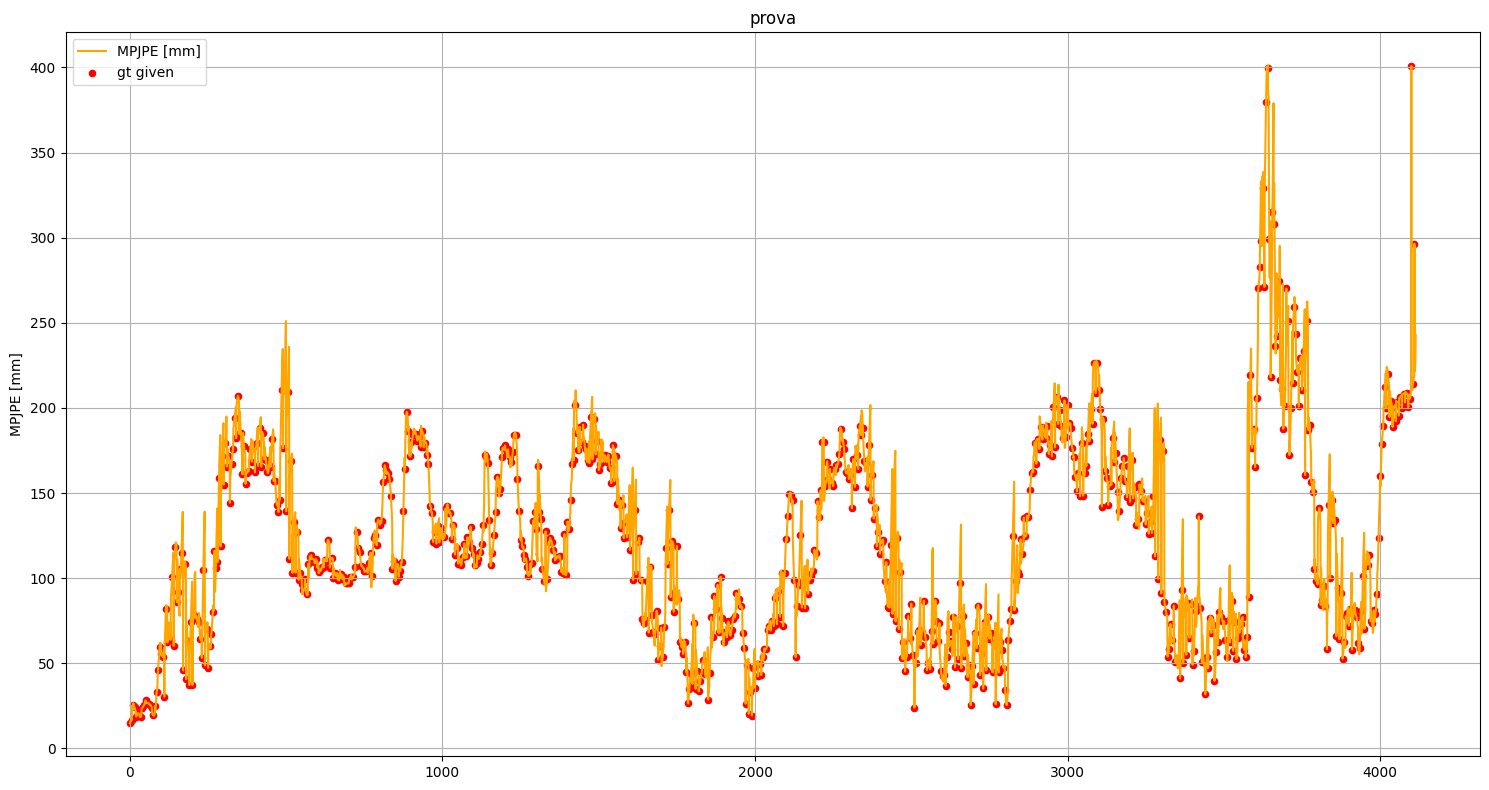

In [31]:
from sf_utils import input_sim, rotation
from sf_utils.metrics import body_pose_metrics
from scipy.spatial.transform import Rotation as R

def quat_to_euler(q, deg = False):
    """NB: It gives the extrinsic angles!!!"""
    r = R.from_quat(np.array([q[1], q[2], q[3], q[0]])) #Vector first
    roll, pitch, yaw = r.as_euler('xyz', degrees=deg)
    return np.array([roll, pitch, yaw])

gui.nativeAPI().clear()
imu_cont = ImuData('./raw_imu_data/imu_s1_acting1.csv')
#imu_cont = ImuData('./totalcapture/imu/s5/walking2/imu_s5_walking2.csv')
imu_cont.read_imu_csv()

imu = imu_cont.acc_read
acc, gyro = imu_cont.get_imu_array(['right_elbow', 'left_elbow', 'sternum'])
quat_gt = imu_cont.get_world_orient(['right_elbow', 'left_elbow', 'sternum'])

""" s = create_body_model('s5/walking2', imu, body_node_list=['humerus_r', 'humerus_l', "thorax"])
s_gt = create_body_model('s5/walking2', imu, body_node_list=['humerus_r', 'humerus_l', "thorax"]) """
s = create_body_model('s1/acting1', imu, body_node_list=['humerus_r', 'humerus_l', "thorax"])
s_gt = create_body_model('s1/acting1', imu, body_node_list=['humerus_r', 'humerus_l', "thorax"])

s._nimble.setVelocities(np.zeros((49,1)))
s._nimble.setAccelerations(np.zeros((49,1)))
start_pos = s._nimble.getPositions()
#pos_gt = compute_gt('s1/acting1', './totalcapture/vicon/')
dt = 1/60
numtaps = 50
low_pass = fir_filter(numtaps)
kf = MultiJointKalman3D(n_joints=49, dt=dt)
cf0 = ComplementaryFilter()
cf1 = ComplementaryFilter()
cf2 = ComplementaryFilter()

R_correction = np.array([np.eye(3), np.eye(3), np.eye(3)])
mm = body_pose_metrics.MetricManager(s, [], pos_gt)
count = 0
R_v_buffer = []
R_t_buffer = []

theta_cam = np.deg2rad(-75)
R_cam_imu = np.array([[np.cos(theta_cam), 0, np.sin(theta_cam)],[0,1,0],[-np.sin(theta_cam),0,np.cos(theta_cam)]])
T=np.array([np.eye(4), np.eye(4), np.eye(4)])
T[:,:3,:3]= rotation.batch_quat_to_rotmat(imu_cont.get_world_orient(['right_elbow', 'left_elbow', 'sternum'])[:,0])
setImuWorldTransform(s,T)
corrected = True
errors = []
marker_gt = new_compute_gt('s1/acting1', './totalcapture/vicon/')
for i in range(0, imu['n_frames']):

    gui.nativeAPI().renderSkeleton(s._nimble)
    gui.nativeAPI().renderSkeleton(s_gt._nimble,prefix='gt',overrideColor=np.array([0,255,0,0.8]))
    for j,sensor in enumerate(s.IMUs):
        plot_imu(s.IMUs[j],axis_length=0.05,imu_key='imu'+str(j))
        
    #print(f"frame {i}: {s_gt._nimble.getJointWorldPositions(s_gt.joints).reshape(-1,3)[[1,3,4,6,7,9],:]}")
    s_gt._nimble.setPositions(pos_gt[i])
    pos_target = None
    valid_pos = False
    valid_pos_right = False
    valid_pos_left = False
    if (i%10)==0:
        camera_pos = getImuWorldPosition(s_gt)[2]
        R_cam_w = getImuWorldOrient(s_gt)[2,:3,:3]@R_cam_imu

        pos_target = (s_gt._nimble.getJointWorldPositions(s_gt.joints)).reshape(-1,3)
        gui.nativeAPI().createSphere(key='target_o', radii=np.array([0.01,0.01,0.01]),pos=pos_target[6,:],color=np.array([0,0,255,1]))
        pos_target = camera_simulation(pos_target, camera_pos=camera_pos, R_cam= R_cam_w)
        #pos_target[[0,2,5,8,10,11]+[3,4,6,9],:] = np.nan #only wrists
        #pos_target[[0,2,5,8,10,11]+[3,9,1,7],:] = np.nan #only elbows
        #pos_target[[0,2,5,8,10,11]+[3,9],:] = np.nan #elbow+wrist
        #pos_target[[0,2,5,8,10,11],:] = np.nan #shoulders+elbows+wrists
        if pos_target is not None: #da riattivare per quello buono
            if not (np.all(np.isnan(pos_target[[6,4]]))): #any
                valid_pos = True
            
            if not np.any(np.isnan(pos_target[6])):
                valid_pos_right = True

            if not np.any(np.isnan(pos_target[4])):
                valid_pos_left = True

    r_0, p_0, y_0 = cf0.update(accel=(R_correction[0]@acc[0,i].T).reshape((3)), gyro=gyro[0,i])
    g_0 = rotation.euler_to_gravity(r_0, p_0, y_0).reshape(-1)
    #g_0 = R_correction[0]@g_0.T
    r_1, p_1, y_1 = cf1.update(accel=(R_correction[1]@acc[1,i].T).reshape((3)), gyro=gyro[1,i])
    g_1 = rotation.euler_to_gravity(r_1, p_1, y_1).reshape(-1)
    #g_1 = R_correction[1]@g_1.T
    r_2, p_2, y_2 = cf2.update(accel=(R_correction[2]@acc[2,i].T).reshape((3)), gyro=gyro[2,i])
    g_2 = rotation.euler_to_gravity(r_2, p_2, y_2).reshape(-1)
    #g_2 = R_correction[2]@g_2.T

    gravity = np.array([g_0,g_1,g_2]).reshape(-1)
    quats = rotation.euler_to_quat(r_0, p_0, y_0)
    #print(f"diff at {i}: {quat_to_euler(quat_gt[0,i], deg = True)-quat_to_euler(quats, deg = True)}")
    no_acc = np.all(np.abs((np.linalg.norm(acc[:,i], axis=-1)-1))>0.5)
    """ if valid_pos or i==0: #circa un trade off brutto
        gravity = None """
    if no_acc or i==0:#usa questo per migliore mpjpe
        gravity = None

    if pos_target is not None or i==0: #usa questo per miglior mae
        gravity = None
    
    """ if not corrected:
        gravity = None """

    estimate_position_from_IMUs_qp(s,acc_target=gravity, gyro_target=None,position_target=pos_target)
    

    if i==0 or (pos_target is not None):

        T = np.array([np.eye(4),np.eye(4),np.eye(4)])
        T[:,:3,:3]= getImuWorldOrient(s).reshape(-1,4,4)[:,:3,:3]

        if i==0 or no_acc: # no_acc:
            cf0.correct(T[0].reshape(4,4))
            cf1.correct(T[1].reshape(4,4))
            cf2.correct(T[2].reshape(4,4))
            
        
        """ if valid_pos_left:
            cf1.correct(T[1].reshape(4,4))
            #cf2.correct(T[2].reshape(4,4))

        if valid_pos_right:
            cf0.correct(T[0].reshape(4,4))
            #cf2.correct(T[2].reshape(4,4)) """

        if valid_pos:
            cf0.correct(T[0].reshape(4,4))
            cf1.correct(T[1].reshape(4,4))
            cf2.correct(T[2].reshape(4,4))
            


    
    q = s._nimble.getPositions().copy()
    q[3:6]=start_pos[3:6]
    q_filt =  q

    """ if not(no_acc and valid_pos):
        if pos_target is None:
            q_filt, vel_filt, acc_filt = kf.update(q, s)
        else:
            q_filt, vel_filt, acc_filt = kf.update(q, s, [1e-2, 1e-2, 1e-1], 1e-4) """

    s._nimble.setPositions(q_filt)
    

    
    pos_est= (s._nimble.getJointWorldPositions(s.joints)).reshape(-1,3)[[3,6,7,9,4,1],:]
    
    #print(pos_est)
    # creating gt
    pos_real = marker_gt[i,1:]
    #print(pos_real)
    #pos_real = target_gt[i].reshape(-1,3)[1:4]- target_gt.reshape(-1,3)[0]
    #[3,6,7,9,4,1]
    pos_error = np.linalg.norm(pos_est-pos_real, axis = -1)
    errors.append(np.mean(pos_error, axis=0).reshape(-1))
    #print(pos_error)
    mm.append_new_pos(q_filt)


plot_error(np.array(errors))


mm.save_metrics()